In [1]:
%matplotlib inline

import dateutil.parser
import datetime
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.contrib import learn

from pymongo import MongoClient
from bson.objectid import ObjectId

from sklearn.metrics import mean_squared_error

from lstm import lstm_model
from data_processing import generate_data, load_csvdata

In [2]:
LOG_DIR = './ops_logs/lstm_weather'
TIMESTEPS = 10
RNN_LAYERS = [{'num_units': 5}]
DENSE_LAYERS = [10, 10]
TRAINING_STEPS = 100000
BATCH_SIZE = 100
PRINT_STEPS = TRAINING_STEPS / 100

# Transform QCLCD Data Function

In [3]:
# downloaded weather data from http://www.ncdc.noaa.gov/qclcd/QCLCD
def load_weather_frame(filename):
    #load the weather data and make a date
    data_raw = pd.read_csv(filename, dtype={'Time': str, 'Date': str})
    data_raw['WetBulbCelsius'] = data_raw['WetBulbCelsius'].astype(float)
    times = []
    for index, row in data_raw.iterrows():
        _t = datetime.time(int(row['Time'][:2]), int(row['Time'][:-2]), 0) #2153
        _d = datetime.datetime.strptime( row['Date'], "%Y%m%d" ) #20150905
        times.append(datetime.datetime.combine(_d, _t))

    data_raw['_time'] = pd.Series(times, index=data_raw.index)
    df =  pd.DataFrame(data_raw, columns=['_time','WetBulbCelsius'])
    return df.set_index('_time')


# Load The Data as CSV 
This is QCLCD data for PDX. It is what will be used to train the model.

In [4]:
# scale values to reasonable values and convert to float
data_weather = load_weather_frame("data/QCLCD_PDX_20150901.csv")
X, y = load_csvdata(data_weather, TIMESTEPS, seperate=False)

# Run The Model and Fit Predictions

In [5]:
regressor = learn.SKCompat(learn.Estimator(
    model_fn=lstm_model(
        TIMESTEPS,
        RNN_LAYERS,
        DENSE_LAYERS
    ),
    model_dir=LOG_DIR
))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': None, '_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_task_type': None, '_environment': 'local', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8d909fb910>, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_master': ''}


In [6]:
# create a lstm instance and validation monitor
validation_monitor = learn.monitors.ValidationMonitor(X['val'], y['val'],
                                                     every_n_steps=PRINT_STEPS,
                                                     early_stopping_rounds=1000)
regressor.fit(X['train'], y['train'],
              monitors=[validation_monitor],
              batch_size=BATCH_SIZE,
              steps=TRAINING_STEPS)

predicted = regressor.predict(X['test'])

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Use `tf.contrib.losses.mean_squared_error` and explicit logits computation.
Instructions for updating:
Use tf.losses.mean_squared_error instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./ops_logs/lstm_weather/model.ckpt-100000
INFO:tensorflow:Saving checkpoints for 100001 into ./ops_logs/lstm_weather/model.ckpt.
INFO:tensorflow:loss = 0.198107, step = 100001
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is dec

INFO:tensorflow:loss = 0.181493, step = 103501 (0.192 sec)
INFO:tensorflow:global_step/sec: 541.342
INFO:tensorflow:loss = 0.208583, step = 103601 (0.185 sec)
INFO:tensorflow:global_step/sec: 558.225
INFO:tensorflow:loss = 0.280774, step = 103701 (0.179 sec)
INFO:tensorflow:global_step/sec: 569.415
INFO:tensorflow:loss = 0.220926, step = 103801 (0.176 sec)
INFO:tensorflow:global_step/sec: 473.108
INFO:tensorflow:loss = 0.21631, step = 103901 (0.211 sec)
INFO:tensorflow:global_step/sec: 546.649
INFO:tensorflow:loss = 0.21958, step = 104001 (0.183 sec)
INFO:tensorflow:global_step/sec: 549.931
INFO:tensorflow:loss = 0.169769, step = 104101 (0.182 sec)
INFO:tensorflow:global_step/sec: 394.056
INFO:tensorflow:loss = 0.229129, step = 104201 (0.254 sec)
INFO:tensorflow:global_step/sec: 471.218
INFO:tensorflow:loss = 0.21783, step = 104301 (0.212 sec)
INFO:tensorflow:global_step/sec: 539.27
INFO:tensorflow:loss = 0.200531, step = 104401 (0.186 sec)
INFO:tensorflow:global_step/sec: 504.701
INFO

INFO:tensorflow:global_step/sec: 480.562
INFO:tensorflow:loss = 0.17757, step = 111801 (0.207 sec)
INFO:tensorflow:global_step/sec: 428.826
INFO:tensorflow:loss = 0.223959, step = 111901 (0.233 sec)
INFO:tensorflow:global_step/sec: 469.417
INFO:tensorflow:loss = 0.198765, step = 112001 (0.213 sec)
INFO:tensorflow:global_step/sec: 485.352
INFO:tensorflow:loss = 0.271067, step = 112101 (0.206 sec)
INFO:tensorflow:global_step/sec: 386.512
INFO:tensorflow:loss = 0.193965, step = 112201 (0.259 sec)
INFO:tensorflow:global_step/sec: 464.537
INFO:tensorflow:loss = 0.208069, step = 112301 (0.215 sec)
INFO:tensorflow:global_step/sec: 463.1
INFO:tensorflow:loss = 0.172712, step = 112401 (0.216 sec)
INFO:tensorflow:global_step/sec: 451.129
INFO:tensorflow:loss = 0.208218, step = 112501 (0.222 sec)
INFO:tensorflow:global_step/sec: 423.357
INFO:tensorflow:loss = 0.165711, step = 112601 (0.236 sec)
INFO:tensorflow:global_step/sec: 449.725
INFO:tensorflow:loss = 0.246768, step = 112701 (0.223 sec)
INF

INFO:tensorflow:loss = 0.281007, step = 120001 (0.185 sec)
INFO:tensorflow:global_step/sec: 525.829
INFO:tensorflow:loss = 0.193503, step = 120101 (0.190 sec)
INFO:tensorflow:global_step/sec: 379.412
INFO:tensorflow:loss = 0.219885, step = 120201 (0.264 sec)
INFO:tensorflow:global_step/sec: 458.205
INFO:tensorflow:loss = 0.308689, step = 120301 (0.218 sec)
INFO:tensorflow:global_step/sec: 408.278
INFO:tensorflow:loss = 0.219953, step = 120401 (0.245 sec)
INFO:tensorflow:global_step/sec: 515.32
INFO:tensorflow:loss = 0.196375, step = 120501 (0.194 sec)
INFO:tensorflow:global_step/sec: 545.56
INFO:tensorflow:loss = 0.147944, step = 120601 (0.184 sec)
INFO:tensorflow:global_step/sec: 548.992
INFO:tensorflow:loss = 0.271161, step = 120701 (0.181 sec)
INFO:tensorflow:global_step/sec: 545.753
INFO:tensorflow:loss = 0.22624, step = 120801 (0.183 sec)
INFO:tensorflow:global_step/sec: 554.296
INFO:tensorflow:loss = 0.203477, step = 120901 (0.180 sec)
INFO:tensorflow:global_step/sec: 528.061
INF

INFO:tensorflow:global_step/sec: 456.913
INFO:tensorflow:loss = 0.175671, step = 128301 (0.219 sec)
INFO:tensorflow:global_step/sec: 551.722
INFO:tensorflow:loss = 0.268732, step = 128401 (0.181 sec)
INFO:tensorflow:global_step/sec: 538.401
INFO:tensorflow:loss = 0.246417, step = 128501 (0.186 sec)
INFO:tensorflow:global_step/sec: 528.025
INFO:tensorflow:loss = 0.185664, step = 128601 (0.190 sec)
INFO:tensorflow:global_step/sec: 555.624
INFO:tensorflow:loss = 0.187962, step = 128701 (0.180 sec)
INFO:tensorflow:global_step/sec: 532.323
INFO:tensorflow:loss = 0.242814, step = 128801 (0.188 sec)
INFO:tensorflow:global_step/sec: 538.59
INFO:tensorflow:loss = 0.226085, step = 128901 (0.186 sec)
INFO:tensorflow:global_step/sec: 446.425
INFO:tensorflow:loss = 0.133513, step = 129001 (0.224 sec)
INFO:tensorflow:global_step/sec: 511.122
INFO:tensorflow:loss = 0.20028, step = 129101 (0.196 sec)
INFO:tensorflow:global_step/sec: 562.981
INFO:tensorflow:loss = 0.206576, step = 129201 (0.178 sec)
IN

INFO:tensorflow:loss = 0.274901, step = 136501 (0.249 sec)
INFO:tensorflow:global_step/sec: 430.946
INFO:tensorflow:loss = 0.212745, step = 136601 (0.232 sec)
INFO:tensorflow:global_step/sec: 526.79
INFO:tensorflow:loss = 0.214224, step = 136701 (0.190 sec)
INFO:tensorflow:global_step/sec: 454.372
INFO:tensorflow:loss = 0.17651, step = 136801 (0.220 sec)
INFO:tensorflow:global_step/sec: 475.576
INFO:tensorflow:loss = 0.308935, step = 136901 (0.215 sec)
INFO:tensorflow:global_step/sec: 420.371
INFO:tensorflow:loss = 0.205038, step = 137001 (0.234 sec)
INFO:tensorflow:global_step/sec: 481.633
INFO:tensorflow:loss = 0.261487, step = 137101 (0.208 sec)
INFO:tensorflow:global_step/sec: 424.246
INFO:tensorflow:loss = 0.219281, step = 137201 (0.236 sec)
INFO:tensorflow:global_step/sec: 499.318
INFO:tensorflow:loss = 0.201297, step = 137301 (0.200 sec)
INFO:tensorflow:global_step/sec: 533.609
INFO:tensorflow:loss = 0.178396, step = 137401 (0.187 sec)
INFO:tensorflow:global_step/sec: 500.872
IN

INFO:tensorflow:global_step/sec: 555.118
INFO:tensorflow:loss = 0.300462, step = 144801 (0.180 sec)
INFO:tensorflow:global_step/sec: 567.724
INFO:tensorflow:loss = 0.229929, step = 144901 (0.176 sec)
INFO:tensorflow:global_step/sec: 566.389
INFO:tensorflow:loss = 0.21524, step = 145001 (0.177 sec)
INFO:tensorflow:global_step/sec: 570.337
INFO:tensorflow:loss = 0.159327, step = 145101 (0.175 sec)
INFO:tensorflow:global_step/sec: 574.963
INFO:tensorflow:loss = 0.191583, step = 145201 (0.174 sec)
INFO:tensorflow:global_step/sec: 577.345
INFO:tensorflow:loss = 0.186643, step = 145301 (0.173 sec)
INFO:tensorflow:global_step/sec: 559.071
INFO:tensorflow:loss = 0.233356, step = 145401 (0.179 sec)
INFO:tensorflow:global_step/sec: 567.563
INFO:tensorflow:loss = 0.165174, step = 145501 (0.176 sec)
INFO:tensorflow:global_step/sec: 564.803
INFO:tensorflow:loss = 0.223568, step = 145601 (0.177 sec)
INFO:tensorflow:global_step/sec: 508.096
INFO:tensorflow:loss = 0.184806, step = 145701 (0.198 sec)
I

INFO:tensorflow:loss = 0.18679, step = 153001 (0.178 sec)
INFO:tensorflow:global_step/sec: 550.055
INFO:tensorflow:loss = 0.250604, step = 153101 (0.182 sec)
INFO:tensorflow:global_step/sec: 554.868
INFO:tensorflow:loss = 0.244158, step = 153201 (0.180 sec)
INFO:tensorflow:global_step/sec: 567.765
INFO:tensorflow:loss = 0.229114, step = 153301 (0.176 sec)
INFO:tensorflow:global_step/sec: 550.831
INFO:tensorflow:loss = 0.246377, step = 153401 (0.182 sec)
INFO:tensorflow:global_step/sec: 554.299
INFO:tensorflow:loss = 0.188778, step = 153501 (0.180 sec)
INFO:tensorflow:global_step/sec: 483.596
INFO:tensorflow:loss = 0.196457, step = 153601 (0.207 sec)
INFO:tensorflow:global_step/sec: 409.829
INFO:tensorflow:loss = 0.244711, step = 153701 (0.244 sec)
INFO:tensorflow:global_step/sec: 535.664
INFO:tensorflow:loss = 0.237381, step = 153801 (0.187 sec)
INFO:tensorflow:global_step/sec: 553.107
INFO:tensorflow:loss = 0.189712, step = 153901 (0.181 sec)
INFO:tensorflow:global_step/sec: 555.5
INF

INFO:tensorflow:global_step/sec: 565.147
INFO:tensorflow:loss = 0.192857, step = 161301 (0.177 sec)
INFO:tensorflow:global_step/sec: 573.257
INFO:tensorflow:loss = 0.267115, step = 161401 (0.174 sec)
INFO:tensorflow:global_step/sec: 559.995
INFO:tensorflow:loss = 0.211048, step = 161501 (0.179 sec)
INFO:tensorflow:global_step/sec: 553.998
INFO:tensorflow:loss = 0.195085, step = 161601 (0.181 sec)
INFO:tensorflow:global_step/sec: 561.067
INFO:tensorflow:loss = 0.21047, step = 161701 (0.178 sec)
INFO:tensorflow:global_step/sec: 559.682
INFO:tensorflow:loss = 0.276416, step = 161801 (0.179 sec)
INFO:tensorflow:global_step/sec: 571.057
INFO:tensorflow:loss = 0.334747, step = 161901 (0.175 sec)
INFO:tensorflow:global_step/sec: 563.456
INFO:tensorflow:loss = 0.237283, step = 162001 (0.178 sec)
INFO:tensorflow:global_step/sec: 558.155
INFO:tensorflow:loss = 0.203709, step = 162101 (0.179 sec)
INFO:tensorflow:global_step/sec: 552.257
INFO:tensorflow:loss = 0.252989, step = 162201 (0.181 sec)
I

INFO:tensorflow:loss = 0.192058, step = 169501 (0.179 sec)
INFO:tensorflow:global_step/sec: 536.204
INFO:tensorflow:loss = 0.244607, step = 169601 (0.187 sec)
INFO:tensorflow:global_step/sec: 529.288
INFO:tensorflow:loss = 0.243744, step = 169701 (0.189 sec)
INFO:tensorflow:global_step/sec: 546.833
INFO:tensorflow:loss = 0.17969, step = 169801 (0.183 sec)
INFO:tensorflow:global_step/sec: 563.495
INFO:tensorflow:loss = 0.193808, step = 169901 (0.177 sec)
INFO:tensorflow:global_step/sec: 562.436
INFO:tensorflow:loss = 0.167089, step = 170001 (0.178 sec)
INFO:tensorflow:global_step/sec: 539.5
INFO:tensorflow:loss = 0.240503, step = 170101 (0.185 sec)
INFO:tensorflow:global_step/sec: 558.653
INFO:tensorflow:loss = 0.228369, step = 170201 (0.179 sec)
INFO:tensorflow:global_step/sec: 552.126
INFO:tensorflow:loss = 0.296148, step = 170301 (0.181 sec)
INFO:tensorflow:global_step/sec: 515.451
INFO:tensorflow:loss = 0.194129, step = 170401 (0.194 sec)
INFO:tensorflow:global_step/sec: 566.312
INF

INFO:tensorflow:global_step/sec: 515.527
INFO:tensorflow:loss = 0.219325, step = 177801 (0.194 sec)
INFO:tensorflow:global_step/sec: 510.033
INFO:tensorflow:loss = 0.274456, step = 177901 (0.196 sec)
INFO:tensorflow:global_step/sec: 562.452
INFO:tensorflow:loss = 0.342176, step = 178001 (0.178 sec)
INFO:tensorflow:global_step/sec: 557.159
INFO:tensorflow:loss = 0.23441, step = 178101 (0.180 sec)
INFO:tensorflow:global_step/sec: 411.164
INFO:tensorflow:loss = 0.225583, step = 178201 (0.244 sec)
INFO:tensorflow:global_step/sec: 471.769
INFO:tensorflow:loss = 0.236033, step = 178301 (0.211 sec)
INFO:tensorflow:global_step/sec: 532.212
INFO:tensorflow:loss = 0.229159, step = 178401 (0.188 sec)
INFO:tensorflow:global_step/sec: 556.415
INFO:tensorflow:loss = 0.198741, step = 178501 (0.180 sec)
INFO:tensorflow:global_step/sec: 532.209
INFO:tensorflow:loss = 0.222611, step = 178601 (0.188 sec)
INFO:tensorflow:global_step/sec: 528.32
INFO:tensorflow:loss = 0.259306, step = 178701 (0.189 sec)
IN

INFO:tensorflow:loss = 0.214031, step = 186001 (0.196 sec)
INFO:tensorflow:global_step/sec: 519.986
INFO:tensorflow:loss = 0.29491, step = 186101 (0.192 sec)
INFO:tensorflow:global_step/sec: 518.884
INFO:tensorflow:loss = 0.215231, step = 186201 (0.193 sec)
INFO:tensorflow:global_step/sec: 545.882
INFO:tensorflow:loss = 0.178994, step = 186301 (0.183 sec)
INFO:tensorflow:global_step/sec: 538.732
INFO:tensorflow:loss = 0.231247, step = 186401 (0.186 sec)
INFO:tensorflow:global_step/sec: 526.915
INFO:tensorflow:loss = 0.251543, step = 186501 (0.190 sec)
INFO:tensorflow:global_step/sec: 514.864
INFO:tensorflow:loss = 0.211156, step = 186601 (0.194 sec)
INFO:tensorflow:global_step/sec: 550.288
INFO:tensorflow:loss = 0.249934, step = 186701 (0.182 sec)
INFO:tensorflow:global_step/sec: 523.709
INFO:tensorflow:loss = 0.255451, step = 186801 (0.191 sec)
INFO:tensorflow:global_step/sec: 547.54
INFO:tensorflow:loss = 0.239683, step = 186901 (0.183 sec)
INFO:tensorflow:global_step/sec: 508.394
IN

INFO:tensorflow:global_step/sec: 499.753
INFO:tensorflow:loss = 0.198431, step = 194301 (0.204 sec)
INFO:tensorflow:global_step/sec: 525.166
INFO:tensorflow:loss = 0.252969, step = 194401 (0.187 sec)
INFO:tensorflow:global_step/sec: 517.754
INFO:tensorflow:loss = 0.223127, step = 194501 (0.193 sec)
INFO:tensorflow:global_step/sec: 523.919
INFO:tensorflow:loss = 0.229531, step = 194601 (0.191 sec)
INFO:tensorflow:global_step/sec: 546.442
INFO:tensorflow:loss = 0.197176, step = 194701 (0.183 sec)
INFO:tensorflow:global_step/sec: 539.544
INFO:tensorflow:loss = 0.159416, step = 194801 (0.185 sec)
INFO:tensorflow:global_step/sec: 558.219
INFO:tensorflow:loss = 0.23909, step = 194901 (0.179 sec)
INFO:tensorflow:global_step/sec: 534.41
INFO:tensorflow:loss = 0.236096, step = 195001 (0.187 sec)
INFO:tensorflow:global_step/sec: 531.618
INFO:tensorflow:loss = 0.230091, step = 195101 (0.188 sec)
INFO:tensorflow:global_step/sec: 547.744
INFO:tensorflow:loss = 0.244952, step = 195201 (0.182 sec)
IN

In [7]:
#not used in this example but used for seeing deviations
rmse = np.sqrt(((predicted - y['test']) ** 2).mean(axis=0))

score = mean_squared_error(predicted, y['test'])
print ("MSE: %f" % score)

MSE: 0.446543


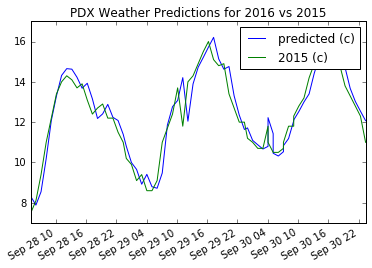

In [8]:
# plot the data
all_dates = data_weather.index.get_values()

fig, ax = plt.subplots(1)
fig.autofmt_xdate()

predicted_values = predicted.flatten() #already subset
predicted_dates = all_dates[len(all_dates)-len(predicted_values):len(all_dates)]
predicted_series = pd.Series(predicted_values, index=predicted_dates)
plot_predicted, = ax.plot(predicted_series, label='predicted (c)')

test_values = y['test'].flatten()
test_dates = all_dates[len(all_dates)-len(test_values):len(all_dates)]
test_series = pd.Series(test_values, index=test_dates)
plot_test, = ax.plot(test_series, label='2015 (c)')

xfmt = mdates.DateFormatter('%b %d %H')
ax.xaxis.set_major_formatter(xfmt)

# ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d %H')
plt.title('PDX Weather Predictions for 2016 vs 2015')
plt.legend(handles=[plot_predicted, plot_test])
plt.show()